# Load Data

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random

import torch.nn.parallel
import torch.backends.cudnn as cudnn

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000)
# use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Spatial size of training images.
# All images will be resized to this size using a transformer. 
image_size = 64

transform_train = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

PATH = '/workspace/data'
trainset = torchvision.datasets.CelebA(root=PATH + '/data_celeba'
            ,split='train',download=True, transform=transform_train)

Files already downloaded and verified


In [3]:
# Number of workers for dataloader
workers = 0
# Batch size during training
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset,
        batch_size=batch_size,shuffle=True, num_workers=workers)

In [4]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() 
                                       and ngpu > 0) else "cpu")
print(device)

cuda:0


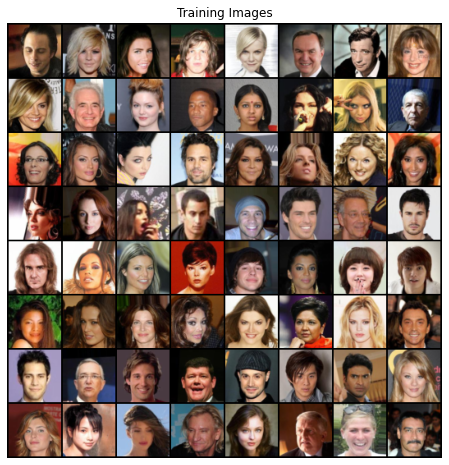

In [5]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
                        real_batch[0].to(device)[:64], padding=2, 
                        normalize=True).cpu(),(1,2,0)))

# Define Generator

In [6]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
def weights_init(m):
    class_name = m.__class__.__name__
    if class_name.find('Conv') !=-1:
        m.weight.data.normal_(0.0,0.02)
        #nn.init.xavier_normal(m.weight.data)
    elif class_name.find('BatchNorm') !=-1:
        m.weight.data.normal_(1.0,0.02)
        #m.bias.data.fill(0)
        torch.nn.init.zeros_(m.bias.data)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
print("Generator's state_dict:\n")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t ", netG.state_dict()[param_tensor].size())

Generator's state_dict:

main.0.weight 	  torch.Size([100, 512, 4, 4])
main.1.weight 	  torch.Size([512])
main.1.bias 	  torch.Size([512])
main.1.running_mean 	  torch.Size([512])
main.1.running_var 	  torch.Size([512])
main.1.num_batches_tracked 	  torch.Size([])
main.3.weight 	  torch.Size([512, 256, 4, 4])
main.4.weight 	  torch.Size([256])
main.4.bias 	  torch.Size([256])
main.4.running_mean 	  torch.Size([256])
main.4.running_var 	  torch.Size([256])
main.4.num_batches_tracked 	  torch.Size([])
main.6.weight 	  torch.Size([256, 128, 4, 4])
main.7.weight 	  torch.Size([128])
main.7.bias 	  torch.Size([128])
main.7.running_mean 	  torch.Size([128])
main.7.running_var 	  torch.Size([128])
main.7.num_batches_tracked 	  torch.Size([])
main.9.weight 	  torch.Size([128, 64, 4, 4])
main.10.weight 	  torch.Size([64])
main.10.bias 	  torch.Size([64])
main.10.running_mean 	  torch.Size([64])
main.10.running_var 	  torch.Size([64])
main.10.num_batches_tracked 	  torch.Size([])
main.12.weight 

In [8]:
from torchsummary import summary
summary(netG.to(device), (100,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 512, 67, 67]         819,200
       BatchNorm2d-2          [-1, 512, 67, 67]           1,024
              ReLU-3          [-1, 512, 67, 67]               0
   ConvTranspose2d-4        [-1, 256, 134, 134]       2,097,152
       BatchNorm2d-5        [-1, 256, 134, 134]             512
              ReLU-6        [-1, 256, 134, 134]               0
   ConvTranspose2d-7        [-1, 128, 268, 268]         524,288
       BatchNorm2d-8        [-1, 128, 268, 268]             256
              ReLU-9        [-1, 128, 268, 268]               0
  ConvTranspose2d-10         [-1, 64, 536, 536]         131,072
      BatchNorm2d-11         [-1, 64, 536, 536]             128
             ReLU-12         [-1, 64, 536, 536]               0
  ConvTranspose2d-13        [-1, 3, 1072, 1072]           3,072
             Tanh-14        [-1, 3, 107

# Define Discriminator

In [9]:
# Size of feature maps in discriminator
ndf = 64

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
print("Discriminator's state_dict:\n")
for param_tensor in netD.state_dict():
    print(param_tensor, "\t ", netD.state_dict()[param_tensor].size())

Discriminator's state_dict:

main.0.weight 	  torch.Size([64, 3, 4, 4])
main.2.weight 	  torch.Size([128, 64, 4, 4])
main.3.weight 	  torch.Size([128])
main.3.bias 	  torch.Size([128])
main.3.running_mean 	  torch.Size([128])
main.3.running_var 	  torch.Size([128])
main.3.num_batches_tracked 	  torch.Size([])
main.5.weight 	  torch.Size([256, 128, 4, 4])
main.6.weight 	  torch.Size([256])
main.6.bias 	  torch.Size([256])
main.6.running_mean 	  torch.Size([256])
main.6.running_var 	  torch.Size([256])
main.6.num_batches_tracked 	  torch.Size([])
main.8.weight 	  torch.Size([512, 256, 4, 4])
main.9.weight 	  torch.Size([512])
main.9.bias 	  torch.Size([512])
main.9.running_mean 	  torch.Size([512])
main.9.running_var 	  torch.Size([512])
main.9.num_batches_tracked 	  torch.Size([])
main.11.weight 	  torch.Size([1, 512, 4, 4])


In [11]:
from torchsummary import summary
summary(netD.to(device), (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [12]:
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Learning rate for optimizers
lr = 0.0002


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%4d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][   0/1272]	Loss_D: 0.9135	Loss_G: 7.5112	D(x): 0.9828	D(G(z)): 0.5401 / 0.0009
[0/5][ 100/1272]	Loss_D: 0.8241	Loss_G: 1.4831	D(x): 0.5171	D(G(z)): 0.0208 / 0.3020
[0/5][ 200/1272]	Loss_D: 0.2167	Loss_G: 2.9352	D(x): 0.8832	D(G(z)): 0.0789 / 0.0719
[0/5][ 300/1272]	Loss_D: 0.4167	Loss_G: 2.5906	D(x): 0.7219	D(G(z)): 0.0347 / 0.1168
[0/5][ 400/1272]	Loss_D: 0.2611	Loss_G: 2.6895	D(x): 0.8591	D(G(z)): 0.0926 / 0.0914
[0/5][ 500/1272]	Loss_D: 0.4730	Loss_G: 2.0988	D(x): 0.7012	D(G(z)): 0.0577 / 0.1685
[0/5][ 600/1272]	Loss_D: 0.2879	Loss_G: 3.0967	D(x): 0.8444	D(G(z)): 0.0874 / 0.0618
[0/5][ 700/1272]	Loss_D: 0.4575	Loss_G: 2.7161	D(x): 0.8048	D(G(z)): 0.1733 / 0.0933
[0/5][ 800/1272]	Loss_D: 0.4478	Loss_G: 5.9529	D(x): 0.9682	D(G(z)): 0.3092 / 0.0037
[0/5][ 900/1272]	Loss_D: 0.3097	Loss_G: 3.3806	D(x): 0.9174	D(G(z)): 0.1831 / 0.0483
[0/5][1000/1272]	Loss_D: 0.8545	Loss_G: 6.1261	D(x): 0.9956	D(G(z)): 0.5089 / 0.0032
[0/5][1100/1272]	Loss_D: 0.6682	Loss_G: